# H-Kr Scattering

In [148]:
import numpy as np
import scipy
import sys
import matplotlib.pyplot as plt
from scipy.integrate import simpson
import random
from random import randint
import scipy.constants as const
from scipy.signal import find_peaks


Descrivere cosa si fa

In [149]:

E = 1.5 #meV
epsilon = 5.99 # meV
sigma = 2. # Angstrom
rmax = 200 # Angstrom
h = 0.01 # spacing
N = rmax/h #number of points
r = np.arange(h/10, rmax, h)
l = 9


# - Masses:
#Kr mass = 83.798 u
#H mass = 1.008 u
# 1 u = 931.494 MeV
m_Kr= 83.798 #u
m_H = 1.008 #u
m = 931.494 * m_Kr * m_H /(m_Kr+ m_H) #MeV/c^2      reduced mass

# - Costants:
h_bar_Js = const.hbar #hbar in Js
h_bar = h_bar_Js / (1.6e-19) # hbar in eVs
c=const.c

# - Useful quantities:
a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*m) #1e-3 for conversion meV, eV -> meV - 1e-10 for conversion m -> Å
b = (4*epsilon * (sigma**12) /(25*a))**(0.1)

In [150]:
# Potential
def V(r,s):
    V = 4*epsilon * ((s/r)**12 - (s/r)**6) #meV
    return V


# Numerov
def Numerov(E,h,l,r,s):
    y = np.zeros(len(r))
    k = np.zeros(len(r))
    # Initialization of values
    
    for j in range(2, len(r)):
        k[j] = (1/a)*(E-V(r[j],s))-l*(l+1)/(r[j])**2
    
  
 
    for j in range(0, len(r)-1):
        
        if r[j]<=sigma/2:
            y[j]=np.exp(-(b/r[j])**5)
        else:
            y[j+1] = (-y[j-1]*(1+h**2/12*k[j-1])+2*y[j]*(1-(5*h**2)/12*k[j]))/((1+h**2/12*k[j+1]))

    return y


# Normalization
def normalize(psi,x):
  """ Normalization of the wavefunction calculing the integral of the wavefunction"""
  # Step 1: Compute the modulus squared of the wave function
  mod_squared_psi = np.abs(psi)**2

  # Step 2: Integrate the modulus squared over all space
  integral_value = simpson(mod_squared_psi, x)

  # Step 3: Calculate the normalization constant
  normalization_constant = 1 / np.sqrt(np.abs(integral_value))

  # Step 4: Apply the normalization constant
  normalized_psi = [y*normalization_constant for y in psi]
  return normalized_psi



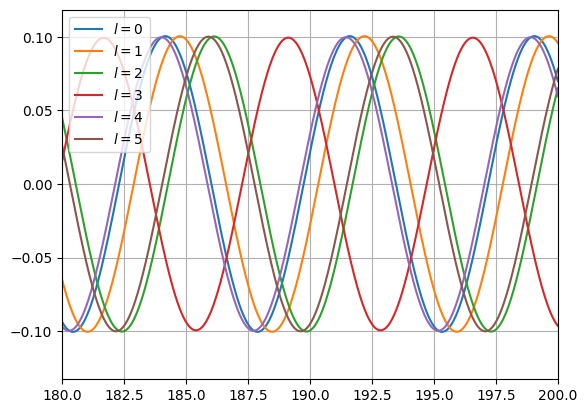

In [151]:
fig, ax = plt.subplots()
ax.set_xlim(180,200)
for j in range(6):
    psi = Numerov(E,h,j,r,sigma)
    PSI = normalize(psi,r)
    ax.plot(r, PSI, label=rf'$l={j}$')   
plt.legend(loc='best')
plt.grid()
plt.show()

step2

In [152]:
# Define Bessel functions

def j_1(r):
    return np.sin(r)/(r**2) - np.cos(r)/r
    
def n_1(r):
    return -np.cos(r)/(r**2) - np.sin(r)/r
    
    
def j_0(r):
    return np.sin(r)/r
    
def n_0(r):
    return -np.cos(r)/r
    
def recursive_bessel(l,sl,sl1,r):
    return ((2*l+1)/(r))*sl - sl1
    
    
def Bessel_l(l,r):
    bess_matj = np.zeros((l,len(r)))
    bess_matn = np.zeros((l,len(r)))

    for j in range(len(r)):
        bess_matj[0][j] = j_0(r[j])
        bess_matn[0][j] = n_0(r[j])
        bess_matj[1][j] = j_1(r[j])
        bess_matn[1][j] = n_1(r[j])
        
    for w in range(2,l):
        for j in range(len(r)):
            bess_matj[w][j] = recursive_bessel(w-1,bess_matj[w-1][j], bess_matj[w-2][j],r[j])
            bess_matn[w][j] = recursive_bessel(w-1,bess_matn[w-1][j], bess_matn[w-2][j],r[j])
            
    return bess_matj, bess_matn
  

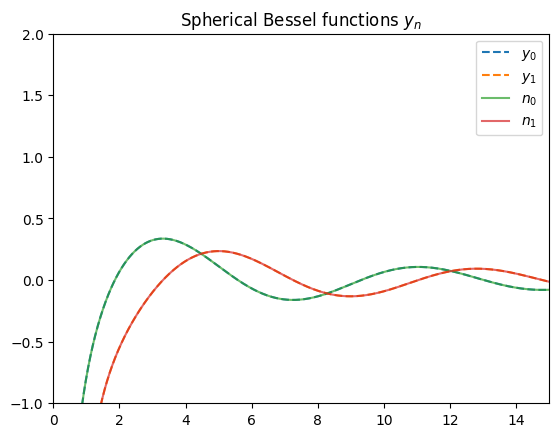

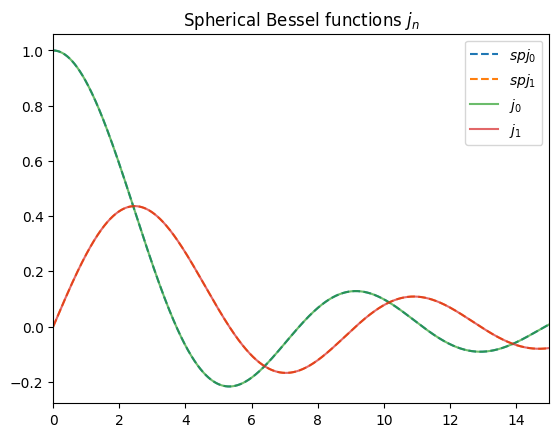

In [153]:
from scipy.special import spherical_jn
from scipy.special import spherical_yn

jj, nn = Bessel_l(l,np.sqrt(1/a*E)*r) 


fig, ax = plt.subplots()
ax.set_xlim(0, 15)
ax.set_ylim(-1,2)
ax.set_title(r'Spherical Bessel functions $y_n$')
for n in np.arange(0, 2):
    ax.plot(r, spherical_yn(n,np.sqrt(1/a*E)*r), label=rf'$y_{n}$', linestyle='dashed')   
for n in np.arange(0, 2):
    ax.plot(r, nn[n][:], label=rf'$n_{n}$', alpha=0.7)
plt.legend(loc='best')
plt.show()


fig, ax = plt.subplots()
ax.set_xlim(0, 15)
ax.set_title(r'Spherical Bessel functions $j_n$')
for n in np.arange(0, 2):
    ax.plot(r, spherical_jn(n, np.sqrt(1/a*E)*r), label=rf'$spj_{n}$', linestyle='dashed')   
for n in np.arange(0, 2):
    ax.plot(r, jj[n][:], label=rf'$j_{n}$', alpha=0.7)
plt.legend(loc='best')
plt.show()

In [154]:
def Phase_shift(r1,r2,r,l,En,lmax,sigma):
    jj, nn = Bessel_l(lmax,np.sqrt(1/a*En)*r)
    psi = Numerov(En,h,l,r,sigma)
    u = normalize(psi,r)
    kk=(u[r1]*r[r2])/(u[r2]*r[r1])
    tan_delta_l=(kk*jj[l][r2]-jj[l][r1])/(kk*nn[l][r2]-nn[l][r1])
    delta_l=np.arctan(tan_delta_l)
    return delta_l


#Define E and l vectors
energy_step = 0.03
Evec = [round(z,3) for z in np.arange(0.0,3.6,energy_step)]
Evec[0] = Evec[1]/10
lvec=[z for z in range(0,l,1)]


In [155]:
rep=10
lmax=l

SHIFTS = np.zeros((len(lvec),len(Evec),rep))

for i in range(len(lvec)):
    for j in range(len(Evec)):
        for k in range(rep):
            r1 =randint(6000,len(r)-1)
            rr=r[r1]*4/5-20*k*h
            r2 = round(rr/h)
            SHIFTS[i][j][k]=Phase_shift(r1,r2,r,lvec[i],Evec[j],lmax,sigma)

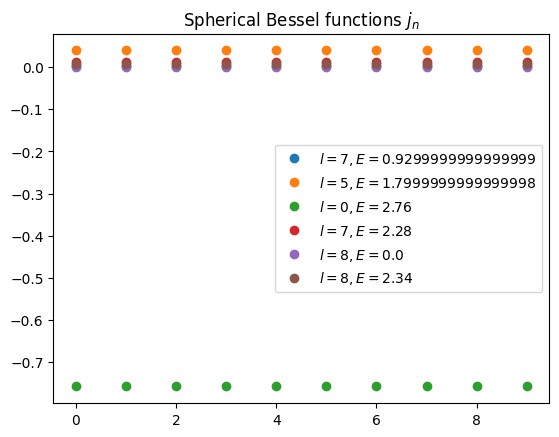

In [156]:
t = [z for z in range(0,rep,1)]

fig, ax = plt.subplots()
ax.set_title(r'Spherical Bessel functions $j_n$')
for j in range(6):
    aa = randint(0,len(Evec)-1)
    bb = randint(0,len(lvec)-1)
    ax.plot(t, SHIFTS[bb][aa][:], 'o',label=rf'$l={bb}, E={aa*energy_step}$')   

plt.legend(loc='best')
plt.show()

Mean and variance of deltas

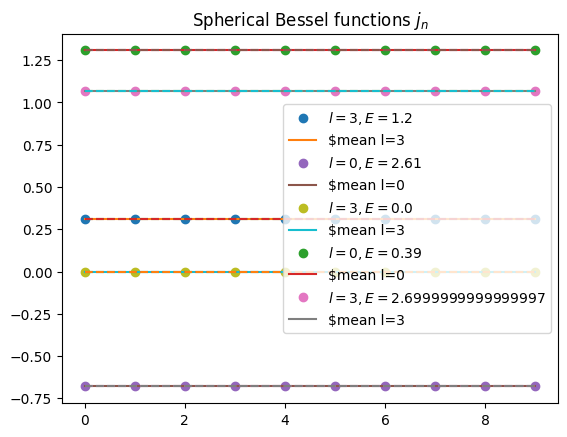

In [157]:
mean_shift=np.zeros((len(lvec),len(Evec)))
var_shift=np.zeros((len(lvec),len(Evec)))

for i in range(len(lvec)):
    for j in range(len(Evec)):
        sum=0
        sumq=0
        for k in range(rep):
            sum+=SHIFTS[i][j][k]
            sumq+=SHIFTS[i][j][k]**2        
        mean_shift[i][j]=sum/rep
        var_shift[i][j]=sumq/rep  - (sum/rep)**2
        

        
fig, ax = plt.subplots()
ax.set_title(r'Spherical Bessel functions $j_n$')
for j in range(5):
    aa = [round(1.2/energy_step),round(2.6/energy_step),round(0.005/energy_step),round(0.4/energy_step),round(2.7/energy_step)]#randint(0,len(Evec)-1)
    bb = [3,0,3,0,3]#randint(0,len(lvec)-1)
    ax.plot(t, SHIFTS[bb[j]][aa[j]][:], 'o',label=rf'$l={bb[j]}, E={aa[j]*energy_step}$')   
    ax.plot(t, np.ones(len(t))*mean_shift[bb[j]][aa[j]], label=rf'$mean l={bb[j]}')
    ax.plot(t, np.ones(len(t))*mean_shift[bb[j]][aa[j]]+var_shift[bb[j]][aa[j]], linestyle='dashed')
    ax.plot(t, np.ones(len(t))*mean_shift[bb[j]][aa[j]]-var_shift[bb[j]][aa[j]],  linestyle='dashed')

plt.legend(loc='best')
plt.show()



Cross section

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


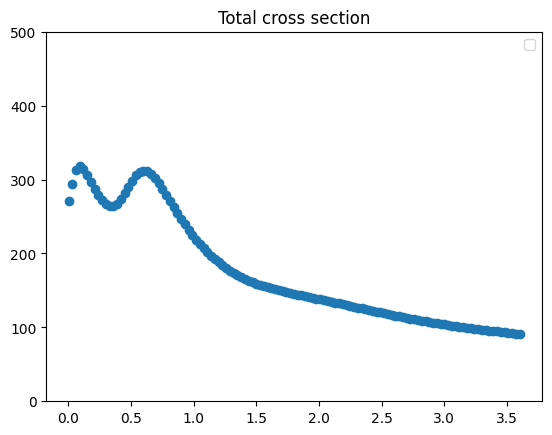

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


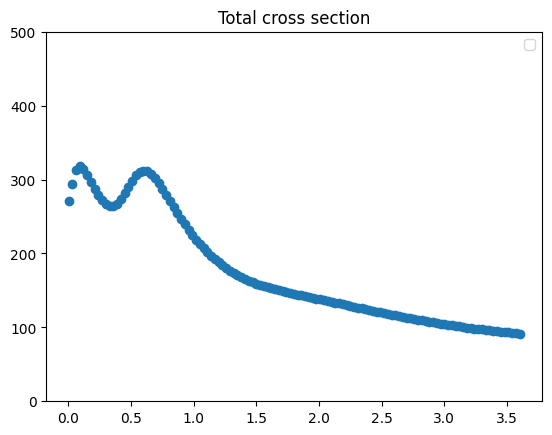

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


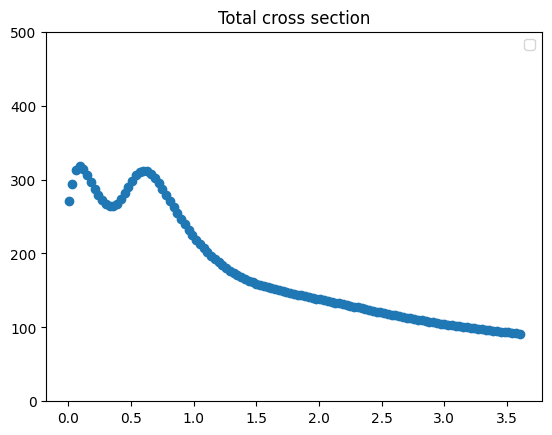

In [158]:
def totalcross(l,shifts):
    cross = np.zeros(len(Evec))
    for i in range(len(Evec)):
        a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*m) #1e-3 for conversion meV, eV -> meV - 1e-10 for conversion m -> Å
        factor= 4 * a * np.pi/Evec[i]
        sum = 0
        for k in range(l):
            mean_tan_l = np.tan(shifts[k][i])
            sin_squared = mean_tan_l**2/(1+mean_tan_l**2)
            sum+=(2*k+1)*sin_squared
        
        cross[i]=(factor*sum)
   
    return cross



cross6 = totalcross(6,mean_shift)
cross7 = totalcross(7,mean_shift)
cross8 = totalcross(8,mean_shift)

fig, ax = plt.subplots()
ax.set_title(r'Total cross section')
ax.set_ylim(0,500)
ax.plot(Evec,cross6,'o')  
plt.legend(loc='best')
plt.show()

fig, ax = plt.subplots()
ax.set_title(r'Total cross section')
ax.set_ylim(0,500)
ax.plot(Evec,cross7,'o')  
plt.legend(loc='best')
plt.show()

fig, ax = plt.subplots()
ax.set_title(r'Total cross section')
ax.set_ylim(0,500)
ax.plot(Evec,cross8,'o')  
plt.legend(loc='best')
plt.show()


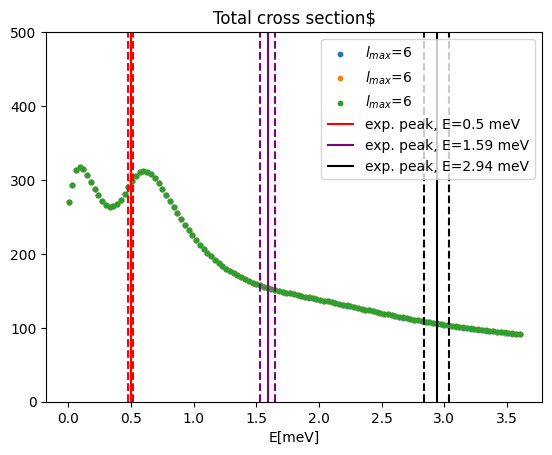

In [159]:
E_exp = [0.50,1.59,2.94] #meV
E_exp_err = [0.02,0.06,0.1] #meV

fig, ax = plt.subplots()
ax.set_title(r'Total cross section$')
ax.set_ylim(0,500)
plt.scatter(Evec,cross6,label='$l_{max}$='f'{6}',s=10)
plt.scatter(Evec,cross7,label='$l_{max}$='f'{6}',s=10)
plt.scatter(Evec,cross8,label='$l_{max}$='f'{6}',s=10) 
plt.xlabel('E[meV]')


plt.vlines(E_exp[0],0,500, color='red', label=f'exp. peak, E={E_exp[0]} meV')
plt.vlines(E_exp[0]+E_exp_err[0],0,500, color='red',linestyle='--')
plt.vlines(E_exp[0]-E_exp_err[0],0,500, color='red',linestyle='--')
plt.vlines(E_exp[1],0,500, color='purple', label=f'exp. peak, E={E_exp[1]} meV')
plt.vlines(E_exp[1]+E_exp_err[1],0,500, color='purple',linestyle='--')
plt.vlines(E_exp[1]-E_exp_err[1],0,500, color='purple',linestyle='--')
plt.vlines(E_exp[2],0,500, color='black', label=f'exp. peak, E={E_exp[2]} meV')
plt.vlines(E_exp[2]+E_exp_err[2],0,500, color='black',linestyle='--')
plt.vlines(E_exp[2]-E_exp_err[2],0,500, color='black',linestyle='--')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


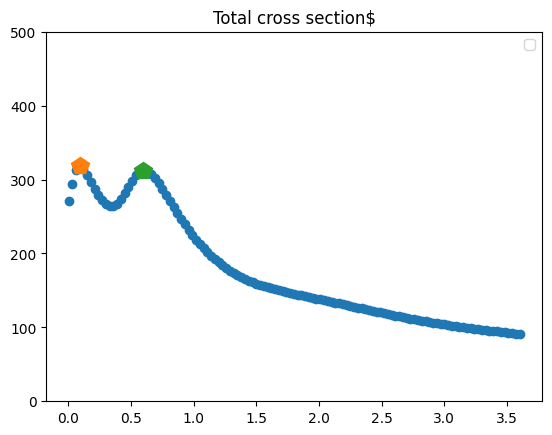

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


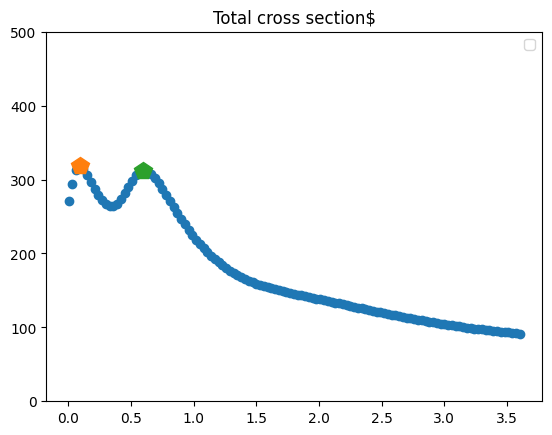

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


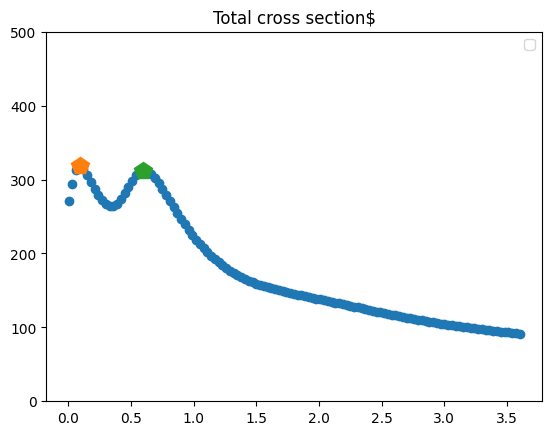

In [160]:
peaks_position6=[]
peaks_position7=[]
peaks_position8=[]
peak6, peak_position6 = find_peaks(cross6)
peaks_position6.append(list(peak6))
peak7, peak_position7 = find_peaks(cross7)
peaks_position7.append(list(peak7))
peak8, peak_position8 = find_peaks(cross8)
peaks_position8.append(list(peak8))



fig, ax = plt.subplots()
ax.set_title(r'Total cross section$')
ax.set_ylim(0,500)
ax.plot(Evec,cross6,'o')
for i in range(len(peak6)):
    ax.plot(Evec[peak6[i]],cross6[peak6[i]],'p',markersize=13)
plt.legend(loc='best')
plt.show()

fig, ax = plt.subplots()
ax.set_title(r'Total cross section$')
ax.set_ylim(0,500)
ax.plot(Evec,cross7,'o')  
for i in range(len(peak7)):
    ax.plot(Evec[peak7[i]],cross7[peak7[i]],'p',markersize=13)
plt.legend(loc='best')
plt.show()

fig, ax = plt.subplots()
ax.set_title(r'Total cross section$')
ax.set_ylim(0,500)
ax.plot(Evec,cross8,'o')  
for i in range(len(peak8)):
    ax.plot(Evec[peak8[i]],cross8[peak8[i]],'p',markersize=13)
plt.legend(loc='best')
plt.show()

In [161]:

E_comp6=[]
for i in range(len(peaks_position6)):
  for j in peaks_position6[i]:
    E_comp6.append(Evec[j])

  
print(E_comp6)
  
E_comp7=[]
for i in range(len(peaks_position7)):
  for j in peaks_position7[i]:
    E_comp7.append(Evec[j])


print(E_comp7)

E_comp8=[]
for i in range(len(peaks_position8)):
  for j in peaks_position8[i]:
    E_comp8.append(Evec[j])

  
  
  
print(E_comp8)


[0.09, 0.6]
[0.09, 0.6]
[0.09, 0.6]


In [162]:
# Calculation of the parameter Delta

E_comp6=np.array(E_comp6, dtype='float32')
E_comp7=np.array(E_comp7, dtype='float32')
E_comp8=np.array(E_comp8, dtype='float32')


for i in range(len(E_comp6)):
  delta6=0
  delta6+=(E_exp[i]-E_comp6[i])**2
  
for i in range(len(E_comp7)):
  delta7=0
  delta7+=(E_exp[i]-E_comp7[i])**2

for i in range(len(E_comp8)):
  delta8=0
  delta8+=(E_exp[i]-E_comp8[i])**2  

  
print(delta6,delta7,delta8)
  


0.980099952793122 0.980099952793122 0.980099952793122


In [163]:
sigma_step = 0.05 #Å
sigmavec = np.arange(2.9,3.5,sigma_step) #Å


deltasigma = np.zeros(len(sigmavec))


for i in range(len(sigmavec)):
    a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*m)
    b = (4*epsilon * (sigmavec[i]**12) /(25*a))**(0.1)
    SHIFTS = np.zeros((len(lvec),len(Evec)))
    for k in range(len(lvec)):
        for j in range(len(Evec)):
            r1 =randint(6000,len(r)-1)
            rr=r[r1]*4/5-20*k*h
            r2 = round(rr/h)
            SHIFTS[k][j]=Phase_shift(r1,r2,r,lvec[k],Evec[j],lmax,sigmavec[i])
    
    crossect = totalcross(6,SHIFTS)
    peak, peak_position = find_peaks(crossect)
    E_comp=[]
    for i in range(len(peak_position)):
        for j in peak_position[i]:
            E_comp.append(Evec[j])
    
    E_comp=np.array(E_comp, dtype='float32')
    delta=0
    for i in range(len(E_comp)):
        delta+=(E_exp[i]-E_comp[i])**2
    
    deltasigma[i]=delta
    

min_delta=min(deltasigma)
index = 0
for j in range(len(deltasigma)):
    deltasigma[j]==min_delta
    index = j

/tmp/ipykernel_6379/4071374647.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  normalization_constant = 1 / np.sqrt(np.abs(integral_value))
/tmp/ipykernel_6379/4071374647.py:41: RuntimeWarning: invalid value encountered in scalar multiply
  normalized_psi = [y*normalization_constant for y in psi]
/tmp/ipykernel_6379/3507627311.py:5: RuntimeWarning: invalid value encountered in scalar divide
  kk=(u[r1]*r[r2])/(u[r2]*r[r1])


In [172]:
a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*m)
b = (4*epsilon * (min_delta**12) /(25*a))**(0.1)
SHIFTS = np.zeros((len(lvec),len(Evec)))
for k in range(len(lvec)):
    for j in range(len(Evec)):
        r1 =randint(6000,len(r)-1)
        rr=r[r1]*4/5-20*k*h
        r2 = round(rr/h)
        SHIFTS[k][j]=Phase_shift(r1,r2,r,lvec[k],Evec[j],lmax,sigmavec[index])
    
crossect = totalcross(6,SHIFTS)
peak, peak_position = find_peaks(crossect)
E_comp=[]
for i in range(len(peak_position)):
    for j in peak_position[i]:
        E_comp.append(Evec[j])
    
E_comp=np.array(E_comp, dtype='float32')
for i in range(len(E_comp)):
    delta=0
    delta+=(E_exp[i]-E_comp[i])**2
    

[26 83] 0


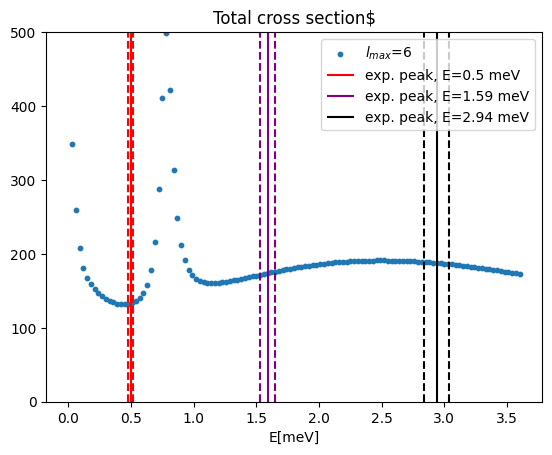

In [175]:

print(peak,delta)


fig, ax = plt.subplots()
ax.set_title(r'Total cross section$')
ax.set_ylim(0,500)
plt.scatter(Evec,crossect,label='$l_{max}$='f'{6}',s=10)
plt.xlabel('E[meV]')


plt.vlines(E_exp[0],0,500, color='red', label=f'exp. peak, E={E_exp[0]} meV')
plt.vlines(E_exp[0]+E_exp_err[0],0,500, color='red',linestyle='--')
plt.vlines(E_exp[0]-E_exp_err[0],0,500, color='red',linestyle='--')
plt.vlines(E_exp[1],0,500, color='purple', label=f'exp. peak, E={E_exp[1]} meV')
plt.vlines(E_exp[1]+E_exp_err[1],0,500, color='purple',linestyle='--')
plt.vlines(E_exp[1]-E_exp_err[1],0,500, color='purple',linestyle='--')
plt.vlines(E_exp[2],0,500, color='black', label=f'exp. peak, E={E_exp[2]} meV')
plt.vlines(E_exp[2]+E_exp_err[2],0,500, color='black',linestyle='--')
plt.vlines(E_exp[2]-E_exp_err[2],0,500, color='black',linestyle='--')
plt.legend()
plt.show()